# SIR with treatment, vaccine, non-permanent immunity, and deaths.

Take the simple SIR model, but now assume that there is a treatment and a vaccine. The treatment reduces the time it takes to recover, but during treatment people are still infectious. The vaccine is not perfect, but vaccinated people are less likely to become infected and they recover faster, and die at lower rate. Also, let's allow recovered people have immunity that is not permanent (but behave as vaccinated for simplicity). The model, then, becomes.   

The relations between the compartments are shown in this figure:
<img src="model.png" alt="isolated" width="650"/>


The system of equations that describe the evolution of the populations is

\begin{align}
 \dot S &= -\lambda S - r_V \ S \\
 \dot V &= -c_V\lambda V + b_R \ R + r_V \ S\\
 \dot I &= \lambda \ S -(h  +\gamma +d) \ I \\
 \dot I_V &= c_V\lambda V -(h +\gamma_V+d_V) \ I_V\\
 \dot T &= h \ (I+I_V) - \gamma_T T \\
 \dot R &= \gamma \ I+\gamma_V \ I_V + \gamma_T \ T - b_R \ R \\
 \dot D & = d \ I + d_V \ I_V\;.
\end{align}

Since people in treatment can still infect people, the infection rate has to account for them. That is, the force of infection gets term compared to the simple SIR model, i.e.

$$
\lambda = \dfrac{\beta \ I +\beta_V \ I_V + \beta_T \ T}{N} \;,
$$

with $\beta_{V}$ the infection rate of people that are vaccinated and $\beta_T$ in treatment.

## Limitations

There are obvious limitations here. I assume that there is no incubation period, there are no asymptomatic people, there are no births. Also, there is no reason natural immunity has to be the same as from vaccination. Finally, People can die during treatment. However, I think it is a good start for a quite general case. 

## Qualitative behavior

Due to the back reaction $R \to V$, the system will reach an equilibrium after "oscillating".  The long-term value of $S+V$ and $I+I_V$ will be non-zero due to this feedback loop. This is a typical behavior in particle interactions, so I don't expect a difference here.

However, since there is a fixed number of people, at $t \to \infty$, everyone will die from this disease.

In [1]:
# LOAD THE PACKAGES:
library(ggplot2)
options(repr.plot.width=15, repr.plot.height=12)
library(deSolve)

In [2]:
Disease <- function(model, initial_values, time){    
    N=sum(initial_values)
    
    sys <- function(time,state,params) { 
                with(as.list(c(state,model)),{
                    lambda <- (beta*I+ betaV*IV + betaT*T)/N  
                    
                    dSdt <- -lambda*S - rV*S
                    dVdt <- -cV*lambda*V + bR*R + rV*S
                    
                    dIdt <- lambda*S - (h+gamma+d)*I
                    dIVdt <- cV*lambda*V - (h+gammaV+dV)*IV
                    
                    dTdt <- h*(I+IV) - gammaT*T
                    
                    dRdt <- gamma*I + gammaV*IV + gammaT*T - bR*R
                    dDdt <- d*I + dV*IV
                    
                    #check that the total population is constant up to numerical error
                    #print(sum(c(dSdt,dVdt,dIdt,dIVdt,dTdt,dRdt,dDdt))/sum(c(S,V,I,IV,T,R,D)))
                    
                    return(list(c(dSdt,dVdt,dIdt,dIVdt,dTdt,dRdt,dDdt)))
                })
            }
    
    with(as.list(c(initial_values)),{
    result <- as.data.frame(ode(
                y     = c(S=S,V=V,I=I,IV=IV,T=T,R=R,D=D),  
                times = time,     
                func  = sys,
                method = "radau",atol = 1e-6, rtol = 1e-6
             ))
    
    with(as.list(result),{
        return(data.frame(time,S,V,I,IV,T,R,D,alive=(S+V+I+IV+T+R+D),tot=(S+V+I+IV+T+R)))
    })
    })
        
}

# Let's see two cases:

1. High mobility, large $\beta$s. Even people in treatment can see relatives...
2. Low mobility, small $\beta$s.

# High mobility

The disease spreads fast, providing natural immunity to the people. The system reaches equilibrium fast, but the high mobility keeps a lot of people constantly infected. Deaths are high. 

In [3]:
disease <- Disease(
                c(
                    beta=1,gamma=1/15.,
                    cV=0.5,betaV=1,gammaV=1/10., rV=1e4,
                    betaT=0.5,gammaT=1/10.,
                    h=1/7.,
                    bR=1/(30*6),
                    d=1e-2,dV=1e-3),
                c(S=5e5-1,V=5e5,I=1,IV=0,T=0,R=0,D=0),
                seq(0,365*5,by=1)
               )

Warning message:
“Removed 7 rows containing missing values (`geom_line()`).”


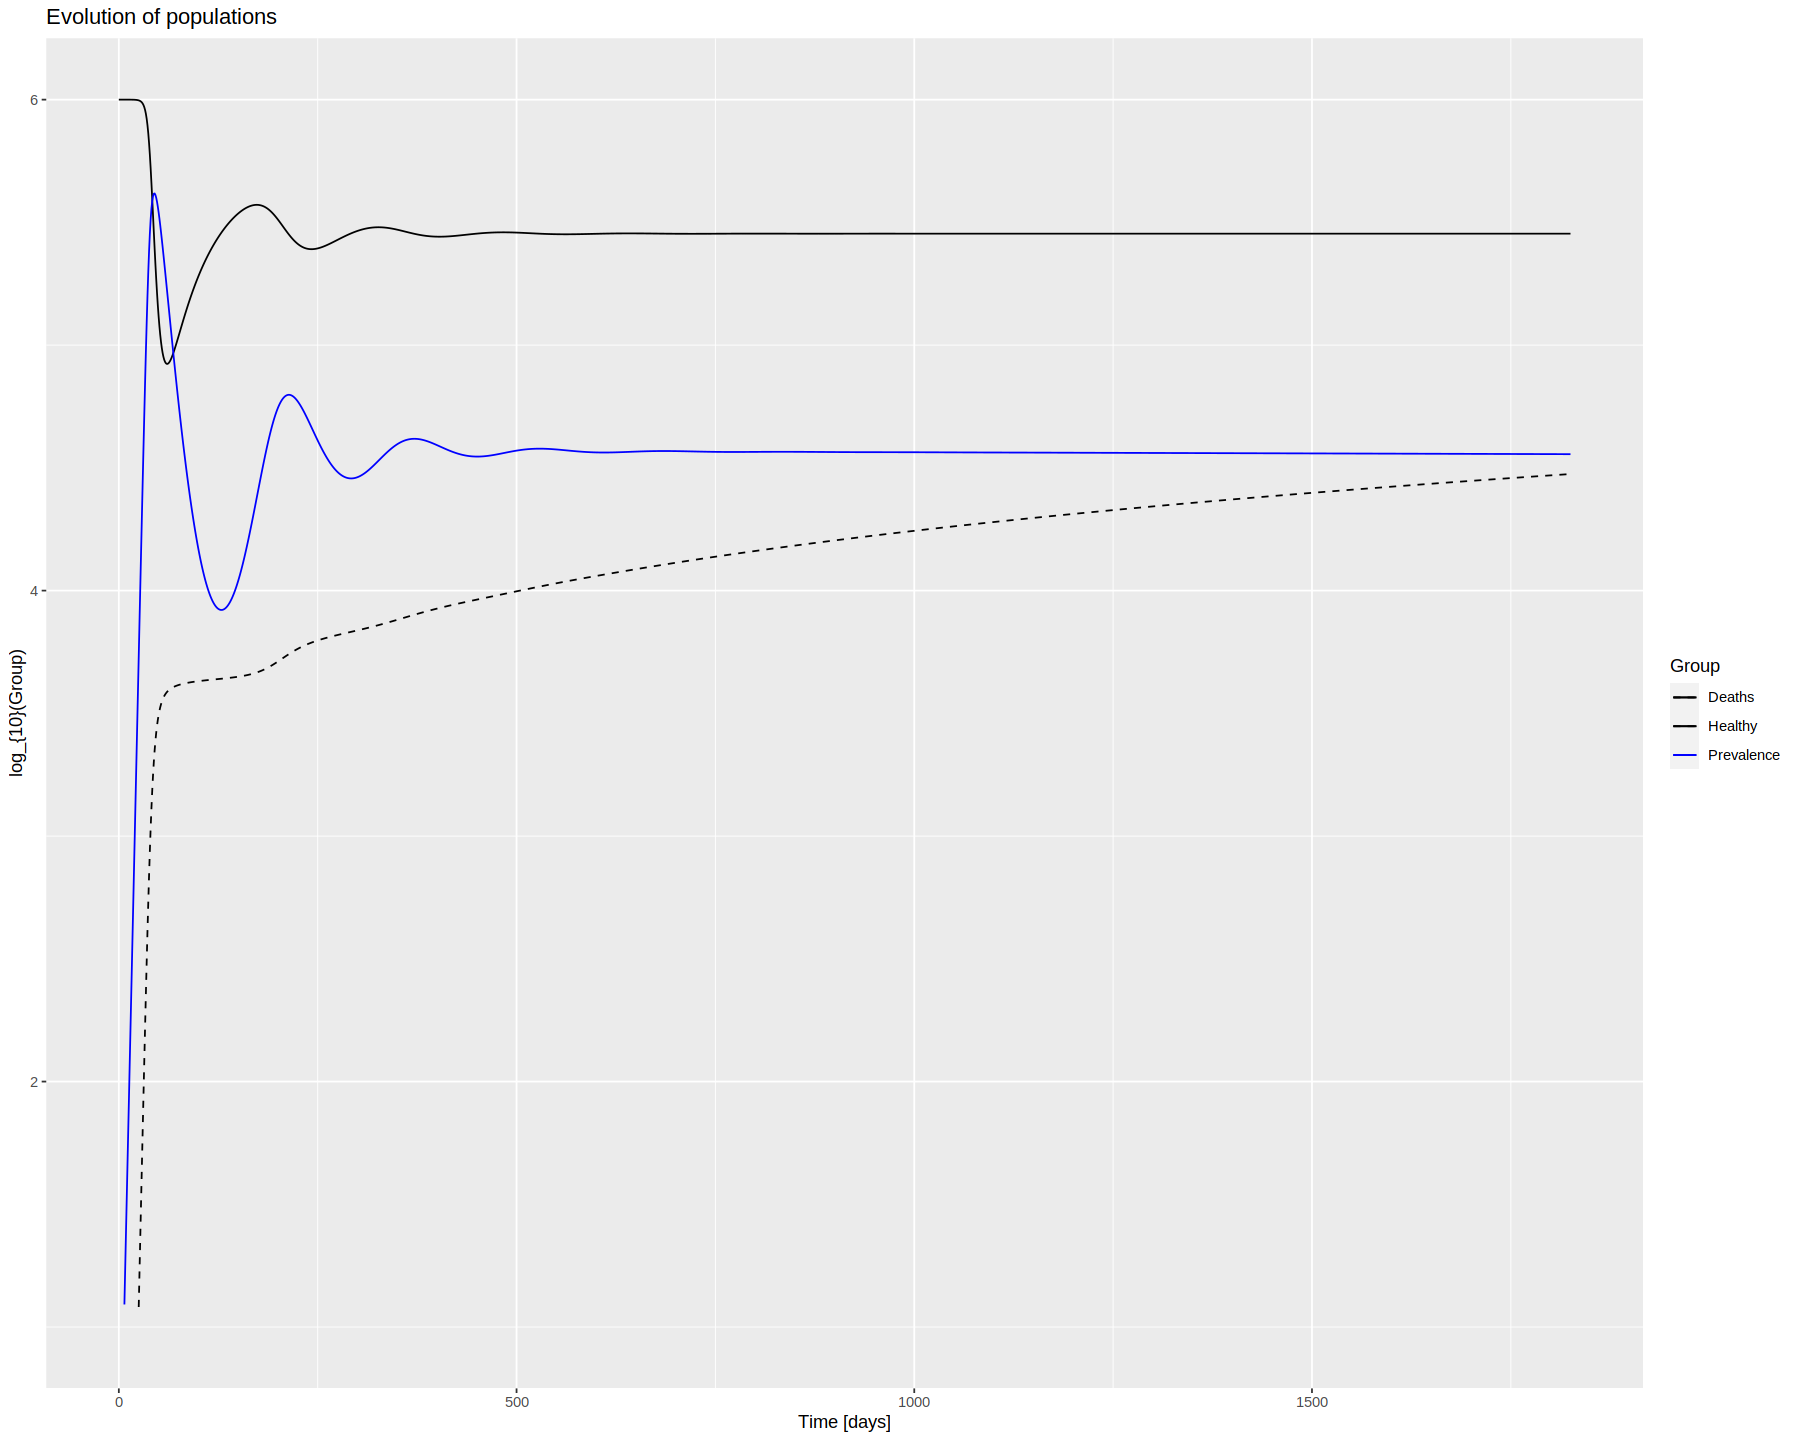

In [4]:
#Evolution of populations
colors <- c("Healthy" = "black", "I" = "red", "Prevalence" = "blue", "Deaths" = "black", "total"="brown")


ggplot(data = disease , aes(x=time)) + 
geom_line(aes(y = log10(S+V), color = "Healthy")) +                 
geom_line(aes(y = log10(I+IV+T), color = "Prevalence")) +                 
geom_line(aes(y = log10(D), color = "Deaths"),linetype="dashed") +            
# geom_line(aes(y = tot/alive, color = "total"),linetype='dashed')   +  

xlim(0,max(disease$time))+
ylim(1,6)+
labs(x = "Time [days]", y = "log_{10}(Group)", color = "Group", title = "Evolution of populations") +
scale_color_manual(values = colors)

In [5]:
disease$D[length(disease$D)]

[1] 29842.91

# Low mobility

The disease spreads slowly. Natural immunity develops slowly. The system reaches equilibrium slowly, but low mobility keeps number of infected in check. Deaths are low. 

In [6]:
disease <- Disease(
                c(
                    beta=0.5,gamma=1/15.,
                    cV=0.5,betaV=0.5,gammaV=1/10., rV=1e4,
                    betaT=0.1,gammaT=1/10.,
                    h=1/7.,
                    bR=1/(30*6),
                    d=1e-2,dV=1e-3),
                c(S=5e5-1,V=5e5,I=1,IV=0,T=0,R=0,D=0),
                seq(0,365*5,by=1)
               )

Warning message:
“Removed 35 rows containing missing values (`geom_line()`).”


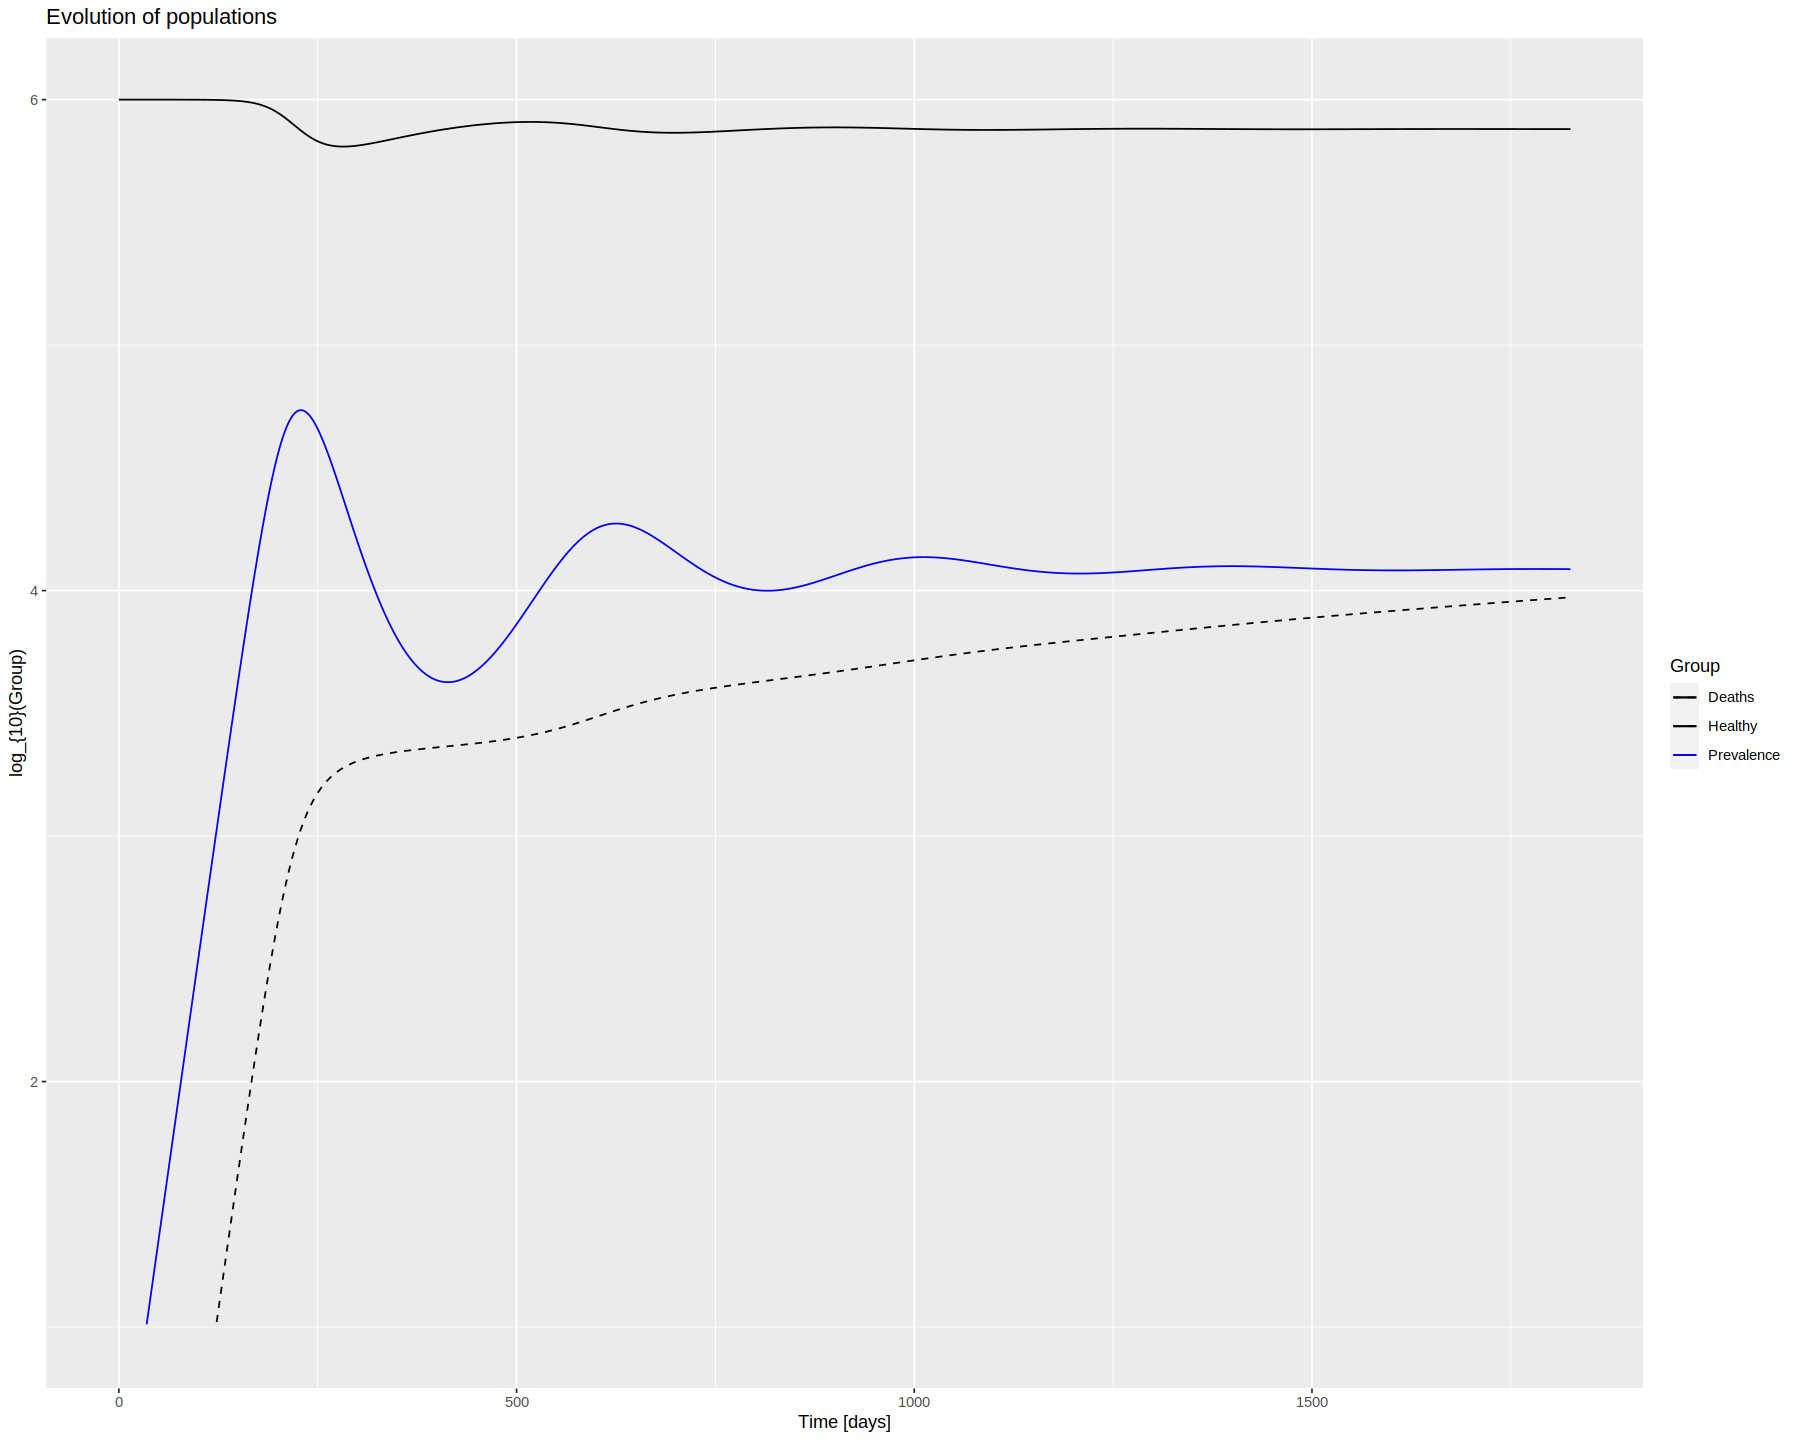

In [7]:
#Evolution of populations
colors <- c("Healthy" = "black", "I" = "red", "Prevalence" = "blue", "Deaths" = "black", "total"="brown")


ggplot(data = disease , aes(x=time)) + 
geom_line(aes(y = log10(S+V), color = "Healthy")) +                 
geom_line(aes(y = log10(I+IV+T), color = "Prevalence")) +                 
geom_line(aes(y = log10(D), color = "Deaths"),linetype="dashed") +            
# geom_line(aes(y = tot/alive, color = "total"),linetype='dashed')   +  

xlim(0,max(disease$time))+
ylim(1,6)+
labs(x = "Time [days]", y = "log_{10}(Group)", color = "Group", title = "Evolution of populations") +
scale_color_manual(values = colors)

In [8]:
disease$D[length(disease$D)]

[1] 9387.184